It is a sample notebook for illustration purposes only. We recommend including the below cell with important candidate instructions.
You may need to update the OS and package versions based on the current environment.

### Environment
Ubuntu 22.04 LTS which includes **Python 3.9.12** and utilities *curl*, *git*, *vim*, *unzip*, *wget*, and *zip*. There is no *GPU* support.

The IPython Kernel allows you to execute Python code in the Notebook cell and Python console.

### Installing packages
- Run `!mamba list "package_name"` command to check the package installation status. For example,

```python
!mamba list numpy
"""
# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
numpy                     1.21.6           py39h18676bf_0    conda-forge
"""
```

    You can also try importing the package.

- Run the `!mamba install "package_name"` to install a package

### Excluding large files
HackerRank rejects any submission larger than **20MB**. Therefore, you must exclude any large files by adding these to the *.gitignore* file.
You can **Submit** code to validate the status of your submission.

## Introduction

The Occupational Employment and Wage Statistics (OEWS) program produces employment and wage estimates annually for nearly 800 occupations. These estimates are available for the nation as a whole, for individual states, and for metropolitan and nonmetropolitan areas; national occupational estimates for specific industries are also available.

## Problem

The data used in this problem is a subset of the OEWS data, which include the 10-th percentile, 25-th percentile, 50-th percentile (a.k.a median), 75-th percentile, and 90-th percentile of the annual salary of a given combination of states, industries, and occupations.

One needs to use the data in _train.csv_ to train a machine learning model to predict the 10-th, 25-th, 50-th, 75-th and 90-th percentiles of the given combinations in _submission.csv_.

## Data

### Independent Variables

There are three independent variable columns:
- PRIM_STATE
- NAICS_TITLE
- OCC_TITLE

indicating the state, industry, and occupation.

NOTE:
- In the _PRIM_STATE_ variable, each category indicates a state postal abbreviation (like "_CA_", "_TX_", etc.) or "_U.S_" as the whole United States. When _PRIM_STATE_ is "_U.S_", it means the percentiles are aggregated across all the states.
- In thes _NAICS_TITLE_, each category indicates an industry sector name (like "_Retail Trade_", "_Manufacturing_") or "_Cross-industry_". When _NAICS_TITLE_ is "_Cross-industry_", it means the percentiles are aggregated across all the industries.

### Target Variables

There are 5 dependent (target) variable columns:
- A_PCT10
- A_PCT25
- A_MEDIAN
- A_PCT75
- A_PCT90

indicating the 10-th percentile, 25-th percentile, median, 75-th percentile, 90-th percentile of the annual base salary given the state, industry, and occupation information.

**IMPORTANT**: the percentiles should follow an increasing order. Namely, the 10-th percentile is less than (<) the 25-th percentile, the 25-th percentile is less than (<) the 50-th percentile, etc.

## Deliverables

### Submit a Well commented Jupyter Notebook

Explore the data, make visualizations, and generate new features if required. Make appropriate plots, annotate the notebook with markdowns and explain necessary inferences. A person should be able to read the notebook and understand the steps taken as well as the reasoning behind them. The solution will be graded on the basis of the usage of effective visualizations to convey the analysis and the modeling process.


### Submit _submission.csv_

In the given _submission.csv_, values in the "A_PCT10", "A_PCT25", "A_MEDIAN", "A_PCT75", and "A_PCT90" columns are constants, and you need to replace them with your model predictions.

**IMPORTANT**:
- please do not change the header given in _submission.csv_, or your predictions may not be evaluated correctly.
- Your Jupyter Notebook should be able to generate your submitted predictions.



## Evaluation Metric

The model performance is evaluated by the mean normalized weighted absolute error (MNWAE) defined as the following:
$$ MNWAE = \frac{1}{n} \sum_{i=1}^{n} \sum_{j \in \{10, 25, 50, 75, 90\}} w_j \times \frac{|y_{i,j}-z_{i,j}|}{z_{i,j}}$$
where $y_{i,j}$ and $z_{i,j}$ are the model estimation and the ground truth of the $i$-th row and $j$-th percentile, and
$$ w_{10} = w_{90} = 0.1, $$
$$ w_{25} = w_{75} = 0.2, $$
$$ w_{50} = 0.4 $$

For example, if

actual percentiles = [10000, 30000, 60000, 80000, 100000],

predicted percentiles = [11000, 33000, 54000, 88000, 120000],

normalized weighted absolute error = 0.1*|11000-10000|/10000+0.2*|33000-30000|/30000+0.4*|54000-60000|/60000+0.2*|88000-80000|/80000+0.1*|120000-100000|/100000 = 0.11

**IMPORTANT**: if the predicted percentiles in any row do not follow an increasing order, all the predictions will be considered as invalid.

## Solution ..

In [70]:
# Import the `pandas` library to load the dataset
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')

In [71]:
df_train = pd.read_csv('train.csv')

In [72]:
df_train

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0
...,...,...,...,...,...,...,...,...
2292,NJ,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.0,NaN
2293,NY,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,NaN,NaN
2294,RI,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.0,NaN
2295,TX,Cross-industry,Legal Occupations,37540.0,51260.0,80850.0,135490.0,NaN


In [73]:
df_train['A_PCT75'].mean()

72875.8579620644

In [74]:
df_train['A_PCT90'].mean()

87937.31232622798

In [75]:
df_train = df_train.fillna({'A_PCT75':72875.8579620644, 'A_PCT90':87937.31232622798})

In [76]:
df_train.isna().sum()

PRIM_STATE     0
NAICS_TITLE    0
OCC_TITLE      0
A_PCT10        0
A_PCT25        0
A_MEDIAN       0
A_PCT75        0
A_PCT90        0
dtype: int64

Text(0.5, 1.0, 'Total Missing Values')

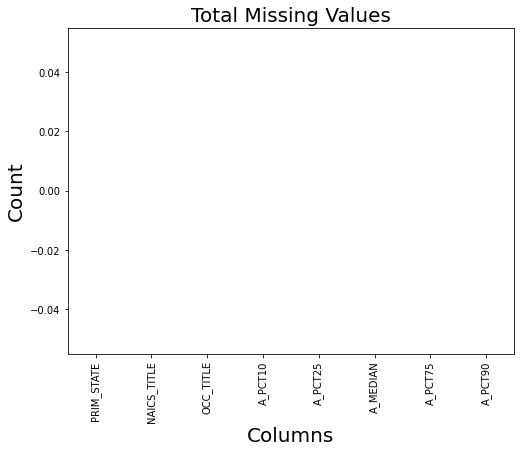

In [77]:
total = df_train.isnull().sum().sort_values(ascending=False)
total_select = total.head(20)
total_select.plot(kind="bar", figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

In [78]:
df_train = pd.get_dummies(data=df_train, columns = ['PRIM_STATE'])

In [79]:
df_train

,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,PRIM_STATE_AK,PRIM_STATE_AL,PRIM_STATE_AR,...,PRIM_STATE_TN,PRIM_STATE_TX,PRIM_STATE_US,PRIM_STATE_UT,PRIM_STATE_VA,PRIM_STATE_VT,PRIM_STATE_WA,PRIM_STATE_WI,PRIM_STATE_WV,PRIM_STATE_WY
0,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.000000,78520.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.000000,153600.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.000000,149070.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.000000,98990.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.000000,133180.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.000000,87937.312326,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2293,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,72875.857962,87937.312326,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2294,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.000000,87937.312326,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2295,Cross-industry,Legal Occupations,37540.0,51260.0,80850.0,135490.000000,87937.312326,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect1 = TfidfVectorizer(ngram_range =(1,1))
tf_idf1 = tf_idf_vect1.fit_transform(df_train["NAICS_TITLE"])
print(tf_idf1.shape)

tf_idf_vect2 = TfidfVectorizer(ngram_range =(1,1))
tf_idf2 = tf_idf_vect2.fit_transform(df_train["OCC_TITLE"])
print(tf_idf2.shape)

array1 = tf_idf1.toarray()
array2 = tf_idf2.toarray()
df1 = pd.DataFrame(array1)
df2 = pd.DataFrame(array2)

df1.columns = ['word1','word2','word3','word4','word5','word6','word7','word8','word9','word10','word11','word12','word13','word14','word15','word16','word17','word18','word19','word20','word21','word22','word23','word24','word25','word26','word27','word28','word29','word30','word31','word32','word33','word34','word35','word36','word37','word38','word39','word40','word41','word42','word43','word44','word45','word46','word47','word48','word49','word50','word51','word52','word53','word54','word55','word56','word57','word58','word59','word60','word61','word62','word63','word64','word65']
df2.columns = ['word66','word67','word68','word69','word70','word71','word72','word73','word74','word75','word76','word77','word78','word79','word80','word81','word82','word83','word84','word85','word86','word87','word88','word89','word90','word91','word92','word93','word94','word95','word96','word97','word98','word99','word100','word101','word102','word103','word104','word105','word106','word107','word108','word109','word110','word111','word112','word113','word114','word115','word116','word117','word118','word119','word120','word121','word122','word123','word124','word125','word126','word127','word128','word129','word130','word131','word132','word133','word134','word135','word136','word137','word138','word139','word140','word141','word142','word143','word144','word145','word146','word147','word148','word149','word150','word151','word152','word153','word154','word155','word156','word157','word158','word159','word160','word161','word162','word163','word164','word165','word166','word167','word168','word169','word170','word171','word172','word173','word174','word175','word176','word177','word178','word179','word180','word181','word182','word183','word184','word185','word186','word187','word188','word189','word190','word191','word192','word193','word194','word195','word196','word197','word198','word199','word200','word201','word202','word203','word204','word205','word206','word207','word208','word209','word210','word211','word212','word213','word214','word215','word216','word217','word218','word219','word220','word221','word222','word223','word224','word225','word226','word227','word228','word229','word230','word231','word232','word233','word234','word235','word236','word237','word238','word239','word240']

data = pd.DataFrame()
data["A_PCT10"] = df_train["A_PCT10"]
data["A_PCT25"] = df_train["A_PCT25"]
data["A_MEDIAN"] = df_train["A_MEDIAN"]
data["A_PCT75"] = df_train["A_PCT75"]
data["A_PCT90"] = df_train["A_PCT90"]

df_train = df_train.drop(['A_PCT10','A_PCT25','A_MEDIAN', 'A_PCT75', 'A_PCT90','NAICS_TITLE','OCC_TITLE'],axis=1)

df = pd.DataFrame()
df = pd.concat([df1,df2,df_train,data],axis=1)
df

(2297, 65)
(2297, 175)


,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,...,PRIM_STATE_VT,PRIM_STATE_WA,PRIM_STATE_WI,PRIM_STATE_WV,PRIM_STATE_WY,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,0.0,0.0,0.000000,0.0,0.256234,0.558075,0.0,0.0,0.0,0.0,...,0,0,0,0,0,32350.0,40200.0,50790.0,62560.000000,78520.000000
1,0.0,0.0,0.000000,0.0,0.350251,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,47860.0,61600.0,87810.0,107460.000000,153600.000000
2,0.0,0.0,0.000000,0.0,0.304582,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,59240.0,63050.0,89740.0,126320.000000,149070.000000
3,0.0,0.0,0.377043,0.0,0.523901,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,37320.0,47630.0,60550.0,77450.000000,98990.000000
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,50130.0,63840.0,81770.0,104530.000000,133180.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,47950.0,73720.0,101550.0,163990.000000,87937.312326
2293,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,47580.0,75920.0,126220.0,72875.857962,87937.312326
2294,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,46400.0,60560.0,98070.0,161120.000000,87937.312326
2295,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,37540.0,51260.0,80850.0,135490.000000,87937.312326


In [81]:
df.isna().sum()

word1       0
word2       0
word3       0
word4       0
word5       0
           ..
A_PCT10     0
A_PCT25     0
A_MEDIAN    0
A_PCT75     0
A_PCT90     0
Length: 297, dtype: int64

In [82]:
### The range of skewness for a fairly symmetrical bell curve 
###distribution is between -0.5 and 0.5; moderate skewness
### is -0.5 to -1.0 and 0.5 to 1.0; and highly skewed distribution 
###is < -1.0 and > 1.0.

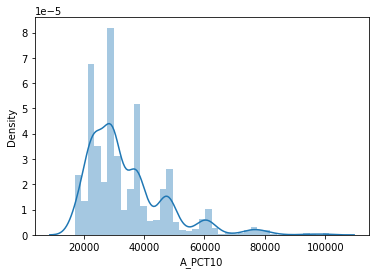

In [83]:
sp_untransformed = sns.distplot(df['A_PCT10'])

In [84]:
print("Skewness: %f" % df['A_PCT10'].skew())

Skewness: 1.578294


In [85]:
df['A_PCT10'] = np.log(df['A_PCT10'])

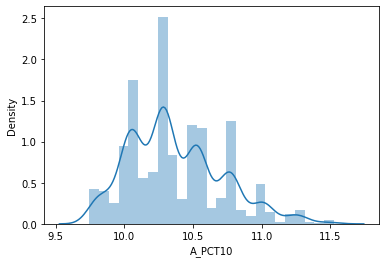

In [86]:
sp_untransformed = sns.distplot(df['A_PCT10'])

In [87]:
print("Skewness: %f" % df['A_PCT10'].skew())

Skewness: 0.596265


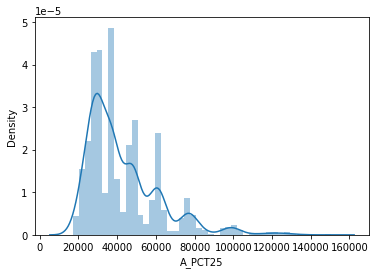

In [88]:
sp_untransformed = sns.distplot(df['A_PCT25'])

In [89]:
print("Skewness: %f" % df['A_PCT25'].skew())

Skewness: 1.578314


In [90]:
df['A_PCT25'] = np.log(df['A_PCT25'])

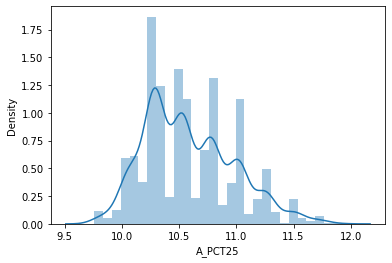

In [91]:
sp_untransformed = sns.distplot(df['A_PCT25'])

In [92]:
print("Skewness: %f" % df['A_PCT25'].skew())

Skewness: 0.545917


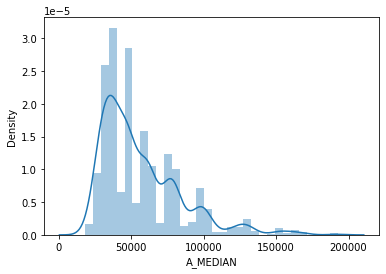

In [93]:
sp_untransformed = sns.distplot(df['A_MEDIAN'])

In [94]:
print("Skewness: %f" % df['A_MEDIAN'].skew())

Skewness: 1.470758


In [95]:
df['A_MEDIAN'] = np.log(df['A_MEDIAN'])

In [96]:
print("Skewness: %f" % df['A_MEDIAN'].skew())

Skewness: 0.426484


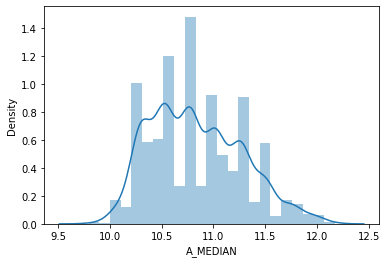

In [97]:
sp_untransformed = sns.distplot(df['A_MEDIAN'])

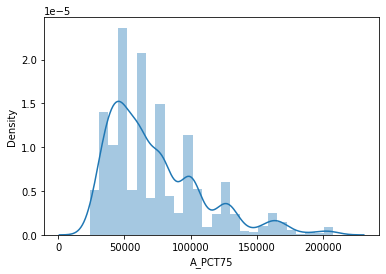

In [98]:
sp_untransformed = sns.distplot(df['A_PCT75'])

In [99]:
df['A_PCT75'] = np.log(df['A_PCT75'])

In [100]:
print("Skewness: %f" % df['A_PCT75'].skew())

Skewness: 0.288458


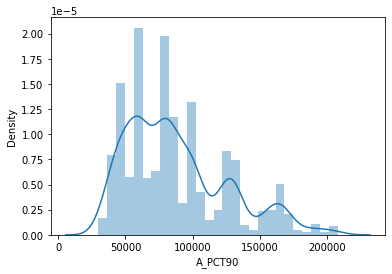

In [101]:
sp_untransformed = sns.distplot(df['A_PCT90'])

In [102]:
print("Skewness: %f" % df['A_PCT90'].skew())

Skewness: 0.862292


In [103]:
df['A_PCT90'] = np.log(df['A_PCT90'])

In [104]:
print("Skewness: %f" % df['A_PCT90'].skew())

Skewness: 0.070388


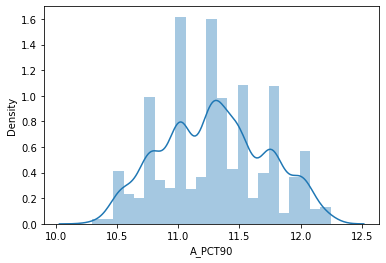

In [105]:
sp_untransformed = sns.distplot(df['A_PCT90'])

<AxesSubplot:>

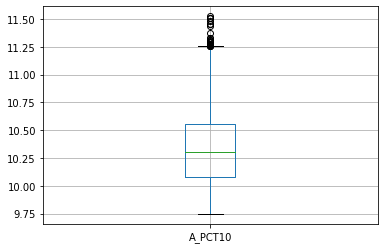

In [106]:
df.boxplot(column='A_PCT10')

<AxesSubplot:>

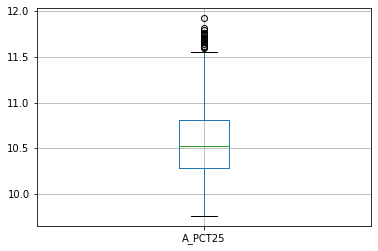

In [107]:
df.boxplot(column='A_PCT25')

<AxesSubplot:>

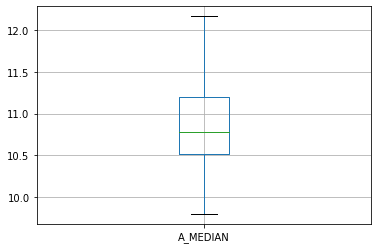

In [108]:
df.boxplot(column='A_MEDIAN')

<AxesSubplot:>

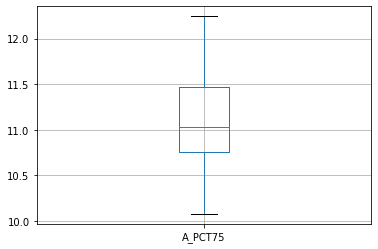

In [109]:
df.boxplot(column='A_PCT75')

<AxesSubplot:>

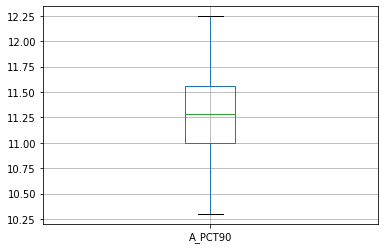

In [110]:
df.boxplot(column='A_PCT90')

In [111]:
df['A_PCT10'].describe()

count    2297.000000
mean       10.369694
std         0.340606
min         9.745663
25%        10.082052
50%        10.301592
75%        10.552683
max        11.525545
Name: A_PCT10, dtype: float64

In [112]:
df['A_PCT10'].mean()

10.369693757626596

In [113]:
df['A_PCT10'].max()

11.52554549632633

In [114]:
##### Assuming step follows A Gaussian Distribution we will calculate the boundaries which differentiates the outliers

upper_boundary=df['A_PCT10'].mean() + 3* df['A_PCT10'].std()
lower_boundary=df['A_PCT10'].mean() - 3* df['A_PCT10'].std()
print(lower_boundary), print(upper_boundary)

9.34787711170124
11.391510403551951


(None, None)

In [115]:
df['A_PCT25'].describe()

count    2297.000000
mean       10.583706
std         0.389502
min         9.757884
25%        10.287388
50%        10.527017
75%        10.806085
max        11.921054
Name: A_PCT25, dtype: float64

In [116]:
df['A_PCT25'].mean()

10.583705791747256

In [117]:
df['A_PCT25'].max()

11.921053690497876

In [118]:
upper_boundary_2=df['A_PCT25'].mean() + 3* df['A_PCT25'].std()
lower_boundary_2=df['A_PCT25'].mean() - 3* df['A_PCT25'].std()
print(lower_boundary_2), print(upper_boundary_2)

9.415200657775518
11.752210925718995


(None, None)

In [119]:
df = df.copy()

In [120]:
df.loc[df['A_PCT10']>=11, 'A_PCT10']=11

In [121]:
df.loc[df['A_PCT25']>=11, 'A_PCT25']=11

In [122]:
df.loc[df['A_PCT10']<9, 'A_PCT10']=9

In [123]:
df.loc[df['A_PCT25']<9, 'A_PCT25']=9

In [124]:
X = df.iloc[:, :-5].values
y = df.iloc[:, -5:].values

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [126]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train, y_train)

In [127]:
y_pred = regr.predict(X_test)

In [128]:
from sklearn.metrics import r2_score
print("R2_score", r2_score(y_test,y_pred))

R2_score 0.802740353695277


In [141]:
def Eval_metric(y, y_hat):
  w=[0.1, 0.2, 0.4, 0.2, 0.1]
  n=y_hat.shape[0]
  sum=0
  for i in range(n):
    j=0
    for y1, y2 in zip(y[i], y_hat[i]):
       sum+=w[j]*(np.abs(y1-y2)/y1).astype(float)
       j+=1
  return sum/n

In [142]:
print(Eval_metric(y_test, y_pred))

0.011767976282822161


In [129]:
df_sub = pd.read_csv('submission.csv')

In [130]:
df_sub

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
2,US,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000
3,US,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000
...,...,...,...,...,...,...,...,...
921,US,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000
922,US,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000
923,WI,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000
924,PA,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000


In [131]:
df_sub.isna().sum()

PRIM_STATE     0
NAICS_TITLE    0
OCC_TITLE      0
A_PCT10        0
A_PCT25        0
A_MEDIAN       0
A_PCT75        0
A_PCT90        0
dtype: int64

In [132]:
df_sub = pd.get_dummies(data=df_sub, columns = ['PRIM_STATE'])

In [133]:
df_sub

,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,PRIM_STATE_AK,PRIM_STATE_AL,PRIM_STATE_AR,...,PRIM_STATE_TN,PRIM_STATE_TX,PRIM_STATE_US,PRIM_STATE_UT,PRIM_STATE_VA,PRIM_STATE_VT,PRIM_STATE_WA,PRIM_STATE_WI,PRIM_STATE_WV,PRIM_STATE_WY
0,Accommodation and Food Services,Other Production Occupations,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Manufacturing,Construction and Extraction Occupations,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Wholesale Trade,Material Moving Workers,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,Utilities,Other Educational Instruction and Library Occu...,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
922,"Arts, Entertainment, and Recreation",Community and Social Service Occupations,10000,20000,30000,40000,50000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
923,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",10000,20000,30000,40000,50000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
924,Cross-industry,Computer and Mathematical Occupations,10000,20000,30000,40000,50000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
res_tf_idf1 = tf_idf_vect1.transform(df_sub["NAICS_TITLE"])
print(tf_idf1.shape)

res_tf_idf2 = tf_idf_vect2.transform(df_sub["OCC_TITLE"])
print(tf_idf2.shape)

res_array1 = res_tf_idf1.toarray()
res_array2 = res_tf_idf2.toarray()
df1_res = pd.DataFrame(res_array1)
df2_res = pd.DataFrame(res_array2)

df1_res.columns = ['word1','word2','word3','word4','word5','word6','word7','word8','word9','word10','word11','word12','word13','word14','word15','word16','word17','word18','word19','word20','word21','word22','word23','word24','word25','word26','word27','word28','word29','word30','word31','word32','word33','word34','word35','word36','word37','word38','word39','word40','word41','word42','word43','word44','word45','word46','word47','word48','word49','word50','word51','word52','word53','word54','word55','word56','word57','word58','word59','word60','word61','word62','word63','word64','word65']
df2_res.columns = ['word66','word67','word68','word69','word70','word71','word72','word73','word74','word75','word76','word77','word78','word79','word80','word81','word82','word83','word84','word85','word86','word87','word88','word89','word90','word91','word92','word93','word94','word95','word96','word97','word98','word99','word100','word101','word102','word103','word104','word105','word106','word107','word108','word109','word110','word111','word112','word113','word114','word115','word116','word117','word118','word119','word120','word121','word122','word123','word124','word125','word126','word127','word128','word129','word130','word131','word132','word133','word134','word135','word136','word137','word138','word139','word140','word141','word142','word143','word144','word145','word146','word147','word148','word149','word150','word151','word152','word153','word154','word155','word156','word157','word158','word159','word160','word161','word162','word163','word164','word165','word166','word167','word168','word169','word170','word171','word172','word173','word174','word175','word176','word177','word178','word179','word180','word181','word182','word183','word184','word185','word186','word187','word188','word189','word190','word191','word192','word193','word194','word195','word196','word197','word198','word199','word200','word201','word202','word203','word204','word205','word206','word207','word208','word209','word210','word211','word212','word213','word214','word215','word216','word217','word218','word219','word220','word221','word222','word223','word224','word225','word226','word227','word228','word229','word230','word231','word232','word233','word234','word235','word236','word237','word238', 'word239', 'word240']

data = pd.DataFrame()
data["A_PCT10"] = df_sub["A_PCT10"]
data["A_PCT25"] = df_sub["A_PCT25"]
data["A_MEDIAN"] = df_sub["A_MEDIAN"]
data["A_PCT75"] = df_sub["A_PCT75"]
data["A_PCT90"] = df_sub["A_PCT90"]

df_sub = df_sub.drop(['A_PCT10','A_PCT25','A_MEDIAN', 'A_PCT75', 'A_PCT90','NAICS_TITLE','OCC_TITLE'],axis=1)

dfp = pd.DataFrame()
dfp = pd.concat([df1_res,df2_res,df_sub,data],axis=1)
dfp

(2297, 65)
(2297, 175)


,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,...,PRIM_STATE_VT,PRIM_STATE_WA,PRIM_STATE_WI,PRIM_STATE_WV,PRIM_STATE_WY,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,0.622086,0.000000,0.0,0.0,0.279562,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
4,0.000000,0.475669,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
922,0.000000,0.000000,0.0,0.0,0.256234,0.558075,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000
923,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,1,0,0,10000,20000,30000,40000,50000
924,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,10000,20000,30000,40000,50000


In [135]:
X = dfp.iloc[:, :-5].values
y = dfp.iloc[:, -5:].values

In [136]:
X_test2= X[-926:]

In [137]:
sub_pred = regr.predict(X_test2)

In [138]:
sub_pred

array([[10.01719164, 10.1710846 , 10.39610684, 10.63587559, 10.85717754],
       [10.20874763, 10.49179315, 10.77985176, 11.11314609, 11.48592377],
       [10.4847297 , 10.68800702, 10.96204421, 11.20059906, 11.40845354],
       ...,
       [10.20416226, 10.47943442, 10.80310524, 11.15872159, 11.51838759],
       [10.63621025, 10.89799373, 11.31674345, 11.63808384, 11.86624271],
       [10.23429132, 10.42505223, 10.68198114, 10.91963966, 11.12413511]])

In [139]:
sub_prediction = pd.DataFrame(sub_pred)

In [140]:
sub_prediction.to_csv('submission_R.csv', index=False)